In [1]:
import numpy as np
import os
from astropy.cosmology import Planck15 as cosmo, z_at_value
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')
import coop_post_processing as cpp
import matplotlib as mpl
from PIL import Image
from scipy import ndimage
import scipy as sp
from scipy import stats
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import stats as st
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
# set plot params
import matplotlib as mpl
import scipy as sp
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
#matplotlib settings
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'STIXGeneral'
# mpl.rc('text', usetex=True)
# mpl.rcParams['figure.figsize'] = [5.0, 4.0]
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['font.size']=14

In [3]:
def get_cov_unoriented(covmat):
    eigvals, eigvects = np.linalg.eig(covmat)
    amps = 2.3*np.sqrt(eigvals)
    return(amps)

def chisq(data_vector, theory_vector, covmat):
    chisq = np.matmul(np.matmul((data_vector-theory_vector).T,np.linalg.inv(covmat)),(data_vector-theory_vector))
    return(chisq)

def chisq_simpler(data_vector, theory_vector, covmat):
    chisq = np.sum((data_vector-theory_vector)**2/np.diag(covmat))
    return chisq

def integrate(profile, r, upper_bound, errors=None):
    reimann_sum = 0
    error_sum   = 0
    delta_r = r[1]-r[0]
    ub_idx = (np.abs(r - upper_bound)).argmin()
    for i in range(ub_idx+1):    
        reimann_sum += r[i]*profile[i]*delta_r
        if errors is not None:
            error_sum += (delta_r*r[i]*errors[i])**2
    return(reimann_sum*np.pi, np.sqrt(error_sum)*np.pi)


def snr_simple(data_vector, null_vector, covmat, chisq_data):
    size = 1*10**6
    exceeds = np.zeros(size)
    sim = np.random.multivariate_normal(null_vector, covmat, size=size)
    for i in range(size):
        chisq_null = chisq_simpler(sim[i], null_vector, covmat)
        if chisq_null > chisq_data:
            exceeds[i] = 1
    print("Number exceeding: ", len(np.where(exceeds == 1)[0]))
    pte = len(np.where(exceeds == 1)[0])/(float(size))
    snr = np.sqrt(2.) * sp.special.erfinv(1.-pte)
    return(pte,snr)

In [4]:
# Define the distance bins
dbins = [[893, 1393], [1493, 1993], [2093, 2593], [2693,3193]]
for dbin in dbins:
    print(z_at_value(cosmo.comoving_distance, (dbin[0]-50)*u.Mpc),z_at_value(cosmo.comoving_distance, (dbin[1]+50)*u.Mpc))

zbins = ['0pt20_0pt36', '0pt36_0pt53', '0pt53_0pt72', '0pt72_0pt94'] # the z bins for number density maps
actpath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"
desunoriented =  "/mnt/raid-cita/mlokken/data/unorienteds/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_unoriented_hpx_4096.fits"

0.20003758488609932 redshift 0.35676599555664823 redshift
0.35676599555664823 redshift 0.529248153677234 redshift
0.529248153677234 redshift 0.7217486066173794 redshift
0.7217486066173794 redshift 0.9396327748501414 redshift


In [5]:
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24

Number exceeding:  0


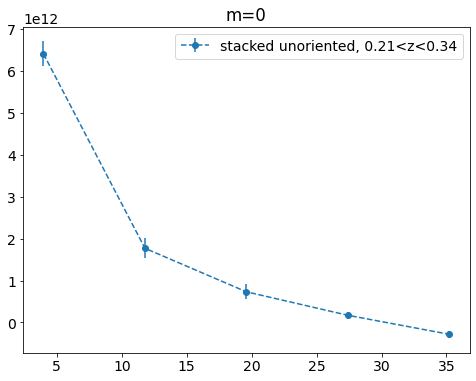

Number exceeding:  39


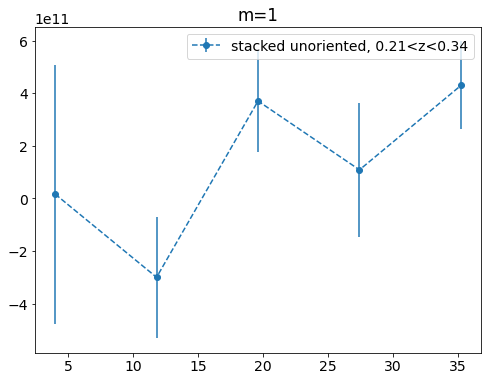

Number exceeding:  315


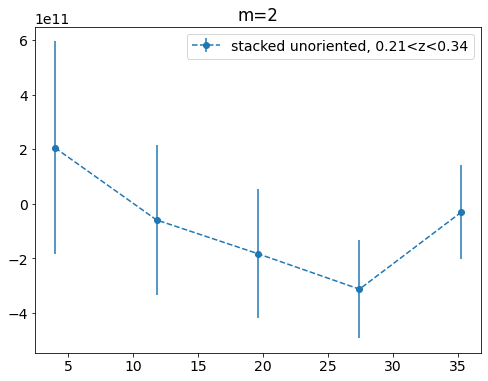

Number exceeding:  80


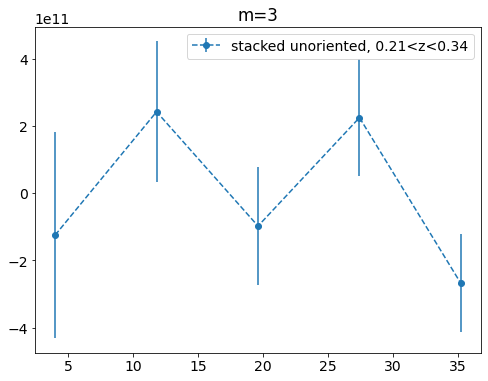

Number exceeding:  27


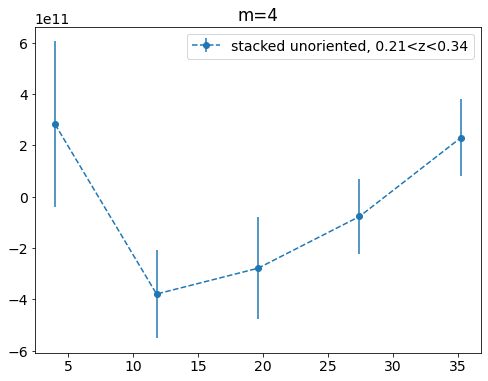

24 24


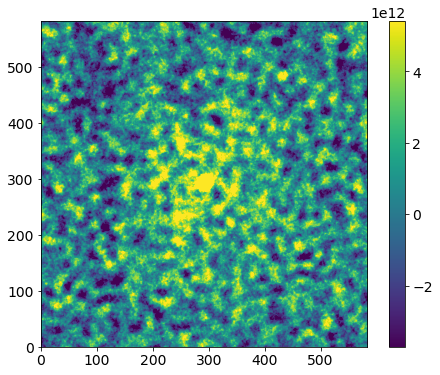

530
Number exceeding:  0


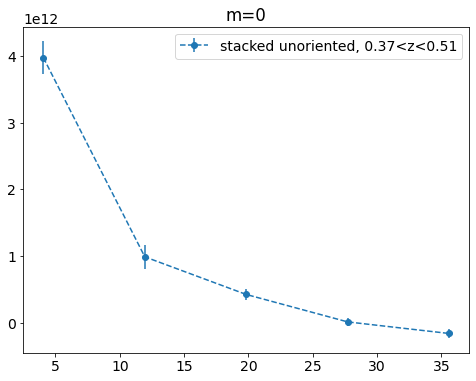

Number exceeding:  83


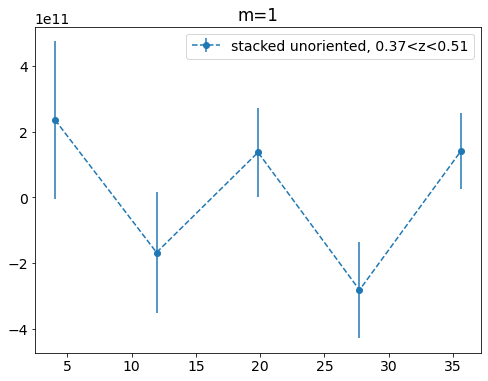

Number exceeding:  969


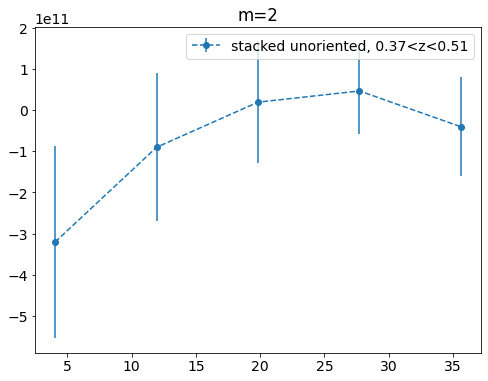

Number exceeding:  872


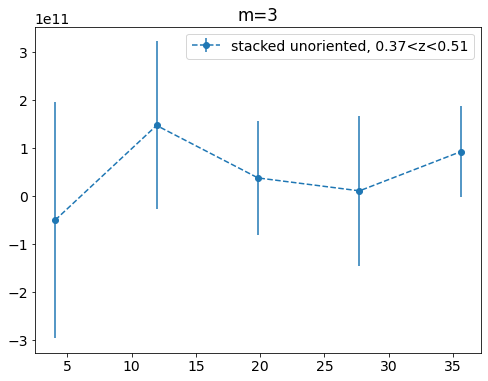

Number exceeding:  660


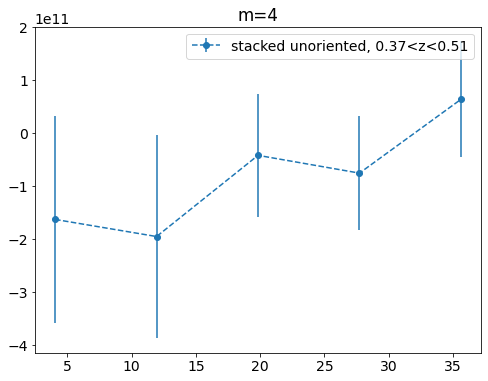

24 24


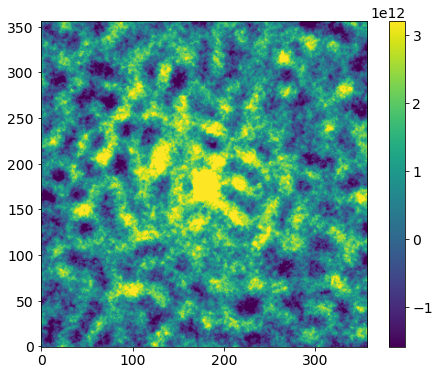

786
Number exceeding:  0


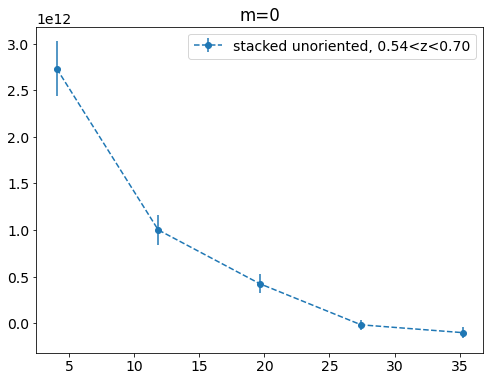

Number exceeding:  631


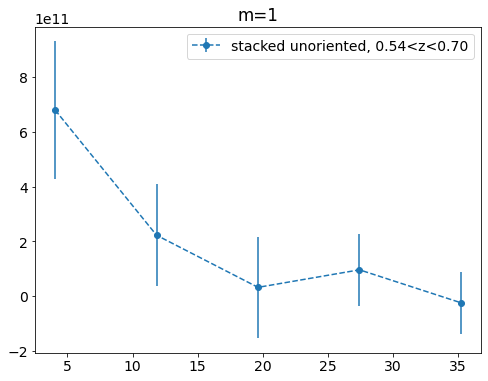

Number exceeding:  299


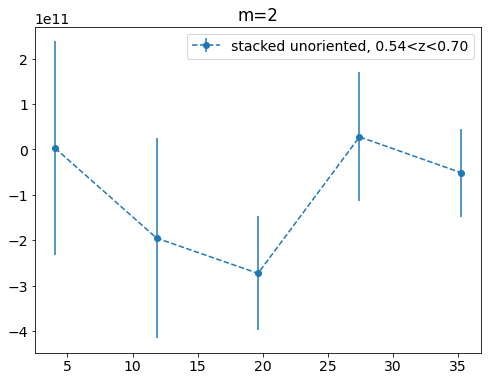

Number exceeding:  968


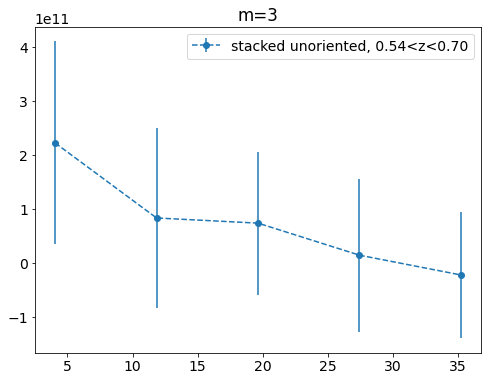

Number exceeding:  954


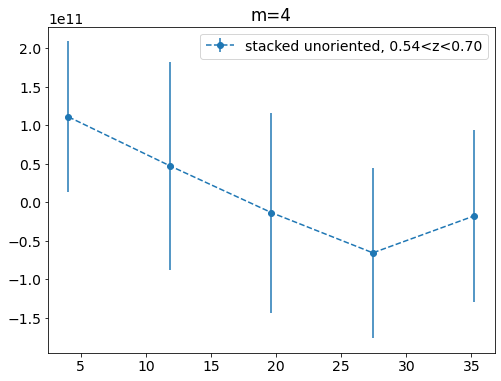

24 24


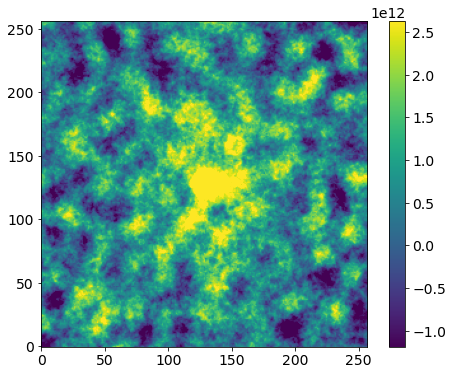

1286
Number exceeding:  190


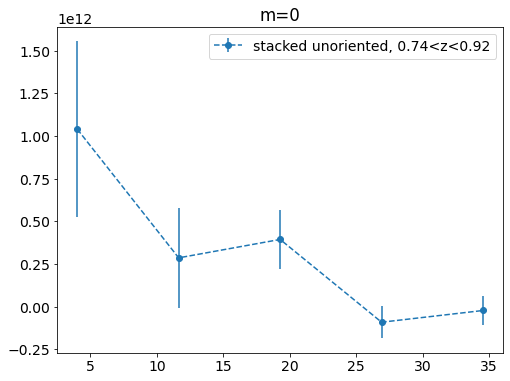

Number exceeding:  767


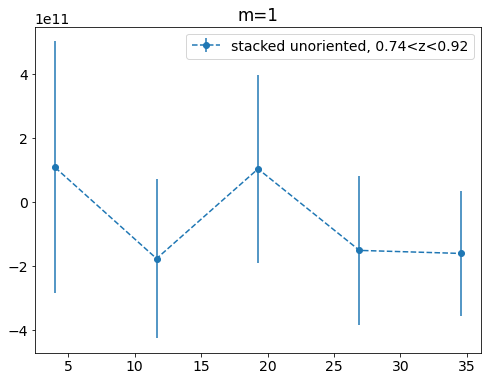

Number exceeding:  106


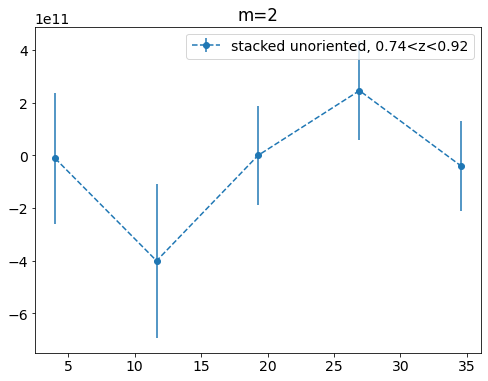

Number exceeding:  595


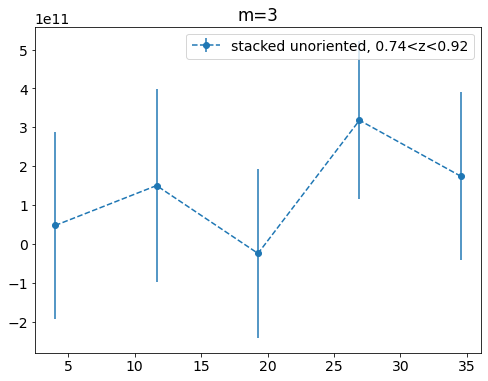

Number exceeding:  298


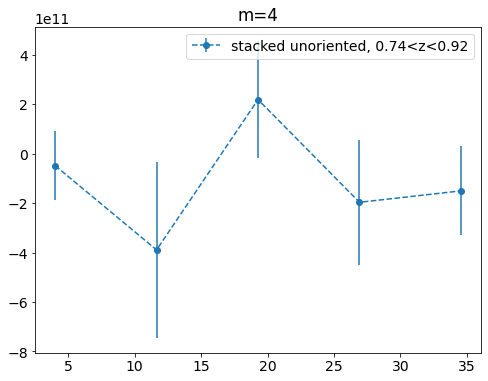

24 24


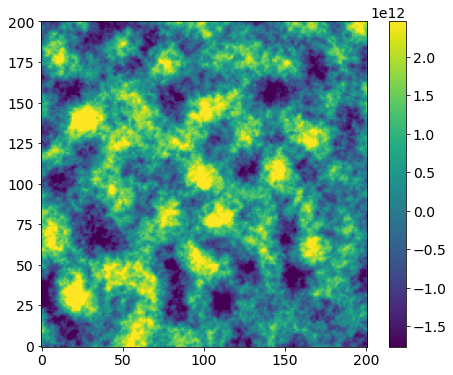

2104


<Figure size 576x432 with 0 Axes>

In [22]:
null_snr = np.zeros((5,len(dbins)))
null_pte = np.zeros((5,len(dbins)))
for c, dbin in enumerate(dbins):
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    # mapstr = 'ilc_SZ_deproj_cib_yy_4096_hpx'
    mapstr = 'kappa_bin4'
    # mapstr = f'DES_maglim_z_{zbins[c]}'
    randrotfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_randrot_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, nreg)
    unorienterrs   = np.load(randrotfile, allow_pickle=True)
    profs = unorienterrs['prof']
    unoriented = cpp.Stack_object(img_splits=unorienterrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=unorienterrs['npks_list'], rad_in_Mpc=unorienterrs['rad_in_Mpc'][4].value)
    idx_r20 = np.where(np.abs(unoriented.r-20) == np.min(np.abs(unoriented.r-20)))[0][0]
    for r in range(unoriented.profile_splits.shape[1]):
        unoriented.profile_splits[0,r,:] -= np.average(unoriented.profile_splits[0,r,:][idx_r20:])
    unoriented.set_average_profiles()
    unoriented.bin_and_get_stats(8) #Mpc
    mlen = unoriented.profile_splits.shape[0]

    for m in range(mlen):
        null_vector = np.zeros(len(unoriented.avg_profiles_binned[m]))
        # print("Chi-squared of unoriented stack w.r.t. zero", st.chisq(unoriented.avg_profiles_binned[m], null_vector, unoriented.covmat_binned[m])/(len(unoriented.avg_profiles[m])-1))
        pte, snr = st.snr_from_pte(unoriented.avg_profiles_binned[m][1:], null_vector[1:], unoriented.covmat_binned[m][1:,1:], chisq_data=None)
        null_snr[m,c] = snr
        null_pte[m,c] = pte

        plt.errorbar(unoriented.r_binned, unoriented.avg_profiles_binned[m], yerr=unoriented.errors_binned[m], fmt='o', linestyle='--', label='stacked unoriented, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
        plt.legend()
        plt.title("m={:d}".format(m))
        plt.show()
        plt.clf()
        
    print(len(unoriented.img_splits), unoriented.Nsamples)
    plt.imshow(unoriented.avg_img, origin='lower', vmin=np.mean(unoriented.avg_img)-2*np.std(unoriented.avg_img), vmax=np.mean(unoriented.avg_img)+2*np.std(unoriented.avg_img))
    plt.colorbar()
    plt.show()
    plt.clf()
    
    print(np.sum(unoriented.Npks_splits))
    # profs_dbin.append(unoriented.avg_profiles_binned[m])
    # errors_dbin.append(errs.errors_binned[m])

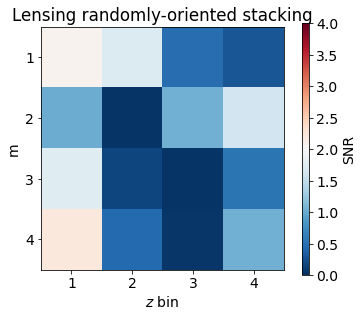

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# scmap = st.shiftedColorMap(plt.cm.RdBu_r, midpoint=2, name='shifted')
snr_plot = ax.imshow(null_snr[1:], cmap='RdBu_r', vmin=0, vmax=4)
ax.set_ylabel("m")
# label y ticks with m values
ax.set_yticks(np.arange(len(null_snr[1:])))
ax.set_yticklabels(["1", "2", "3", "4"])
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax.set_xticks(np.arange(len(dbins)))
ax.set_xticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax.set_xlabel(r"$z$ bin")
plt.title("Lensing randomly-oriented stacking")
# add an axis for a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(snr_plot, cax=cbar_ax, label="SNR")
# centered title
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/{:s}_randoriented_nulltest.pdf".format(mapstr), bbox_inches="tight")
plt.show()

(75.0, 125.0)

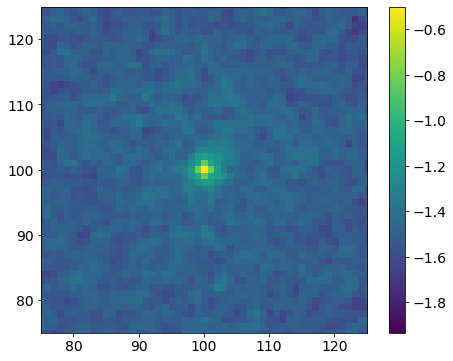

In [12]:
# plt.imshow(unoriented.avg_img, origin='lower', vmin=np.mean(unoriented.avg_img)-8*np.std(unoriented.avg_img), vmax=np.mean(unoriented.avg_img)+8*np.std(unoriented.avg_img))
plt.imshow(np.log10(unoriented.avg_img), origin='lower', vmax=-.5)
plt.colorbar()
# zoom in on the center
plt.xlim(75,125)
plt.ylim(75,125)

In [25]:
profs_dbin = []
errors_dbin = []
zlow = z_at_value(cosmo.comoving_distance, 893*u.Mpc)
zhi = z_at_value(cosmo.comoving_distance, 3193*u.Mpc)
null_snr_tot = np.zeros((5,1))
null_pte_tot = np.zeros((5,1))
randrotfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_893_3193Mpc_{:s}20pt0_randrot_{:d}reg_m0to5_profiles.pkl".format(mapstr, pt_selection_str, nreg)
unoriented   = np.load(randrotfile, allow_pickle=True)
profs = unoriented['prof']
unoriented = cpp.Stack_object(img_splits=unoriented['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=unoriented['npks_list'], rad_in_Mpc=unoriented['rad_in_Mpc'][0].value)
idx_r20 = np.where(np.abs(unoriented.r-20) == np.min(np.abs(unoriented.r-20)))[0][0]
for r in range(unoriented.profile_splits.shape[1]):
    unoriented.profile_splits[0,r,:] -= np.average(unoriented.profile_splits[0,r,:][idx_r20:])
unoriented.set_average_profiles()
unoriented.bin_and_get_stats(8) #Mpc
mlen = unoriented.profile_splits.shape[0]

for m in range(mlen):
    null_vector = np.zeros(len(unoriented.avg_profiles_binned[m]))
    # print("Chi-squared of mask stack w.r.t. zero", st.chisq(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m])/(len(mask.avg_profiles[m])-1))
    pte, snr = st.snr_from_pte(unoriented.avg_profiles_binned[m], null_vector, unoriented.covmat_binned[m], chisq_data=None)
    null_snr_tot[m,0] = snr
    null_pte_tot[m,0] = pte

    plt.errorbar(unoriented.r_binned, unoriented.avg_profiles_binned[m], yerr=unoriented.errors_binned[m], fmt='o', linestyle='--', label='stacked mask, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    plt.legend()
    plt.title("m={:d}".format(m))
    plt.show()
    plt.clf()
    
    

plt.imshow(unoriented.avg_img, origin='lower')
plt.colorbar()
plt.show()
plt.clf()

# print(mask.Npks_splits)
# profs_dbin.append(mask.avg_profiles_binned[m])
# errors_dbin.append(mask.errors_binned[m])



FileNotFoundError: [Errno 2] No such file or directory: '/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/DES_maglim_z_0pt72_0pt94_redmapper_lambdagt20_combined_893_3193Mpc_nugt2_egtpt3_20pt0_norot_24reg_m0to5_profiles.pkl'

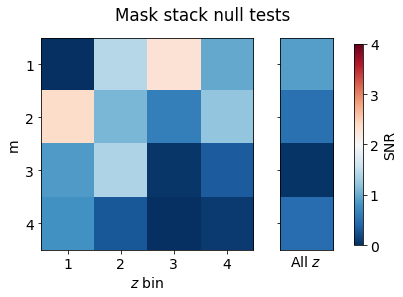

In [18]:
# set up figure with shared y and ratio 4 to 1
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
# scmap = st.shiftedColorMap(plt.cm.RdBu_r, midpoint=2, name='shifted')
snr_plot = ax[0].imshow(null_snr[1:], cmap='RdBu_r', vmin=0, vmax=4)
ax[0].set_ylabel("m")
ax[0].set_yticks(np.arange(len(null_snr[1:])))
ax[0].set_yticklabels(["1", "2", "3", "4"])
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax[0].set_xticks(np.arange(len(dbins)))
ax[0].set_xticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax[0].set_xlabel(r"$z$ bin")
# add an axis for a colorbar
# centered title
ax[1].imshow(null_snr_tot[1:], cmap='RdBu_r', vmin=0, vmax=4)
ax[1].set_xlabel(r"All $z$")
ax[1].set_xticks([])
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(snr_plot, cax=cbar_ax, label="SNR")
plt.suptitle("Mask stack null tests")
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/{:s}_snr_test_unoriented_allz.pdf".format(mapstr), bbox_inches="tight")
plt.show()
